# (06) fast jacobian

**Motivation**: host = ```chewie```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: chewie

## Poisson 

**Task:** reproduce gold standard but with 2/3 epochs (# iters) + no warm restart?

Dataset: MNIST

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|mlp')

seq_len = 10

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_tr['kl_beta'] = 4/8 * seq_len

cfg_tr['warm_restart'] = 0

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

105000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  467.4 K   |
|     ———     |    ———     |
|    layer    |  467.4 K   |
+-------------+------------+

poisson_MNIST_t-10_z-[128]_<jacob|mlp>
b200-ep350-lr(0.002)_beta(5:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_15,17:31)

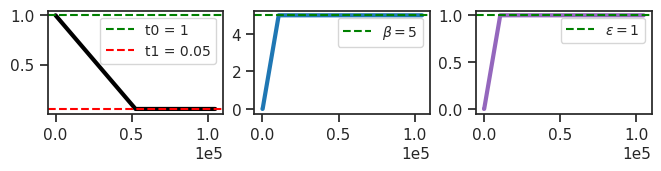

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  467.4 K   |
|     ———      |    ———     |
|     dec      |  467.1 K   |
+--------------+------------+

In [7]:
vae.layer.n_exp

tensor([271, 271, 271, 271, 271, 271, 271, 271, 271, 271], device='cuda:0',
       dtype=torch.int32)

In [8]:
vae.cfg.track_stats

True

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 10, 'n_latents': [128], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'MNIST', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_MNIST_t-10_z-[128]_<jacob|mlp>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_MNIST_t-10_z-[128]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 350, 'batch_size': 200, 'file_name': None, 'warm_restart': 0, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 345.0, 'eta_min': 1e-05}, 'ema_rate': None, 'grad_clip': 50,
'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 5.0, 'kl_beta_min': 0.0001, 
'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 'kl_const_portion':
0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

In [10]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=234, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=234, out_features=428, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=428, out_features=784, bias=True)
)

### Fit model

In [11]:
tr.train()

epoch # 350, avg loss: 18.218695: 100%|███████| 350/350 [58:12<00:00,  9.98s/it]


**Task:** now testing the effect of warm restarts

- Done: attempting to reproduce gold standard using 350 epochs (~2/3 original # iters)

- **Conclusion:** It hurt a bit. For the final paper, use >= 150k iters 

In [12]:
print(vae.layer.n_exp)

tensor([17, 26, 35, 41, 45, 48, 50, 51, 52, 53], device='cuda:0',
       dtype=torch.int32)

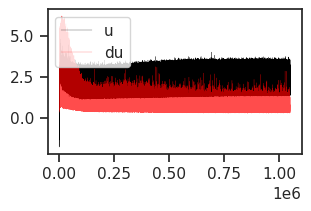

In [13]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

fig, ax = create_figure()
ax.plot(u_max, color='k', label='u', lw=0.2)
ax.plot(du_max, color='r', label='du', alpha=0.7, lw=0.2)
ax.legend()
plt.show()

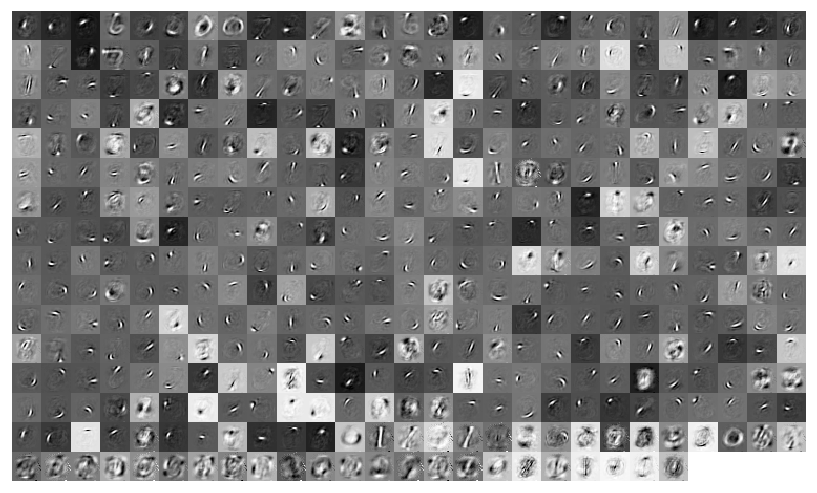

In [14]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))
tr.model.show(order=np.argsort(norms), dpi=120, pad=0);

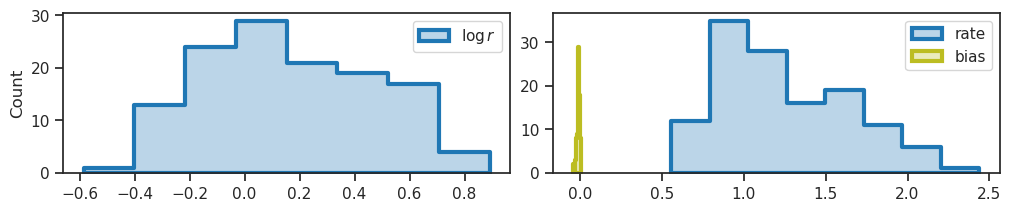

In [15]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [16]:
dead = log_rate < -1
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

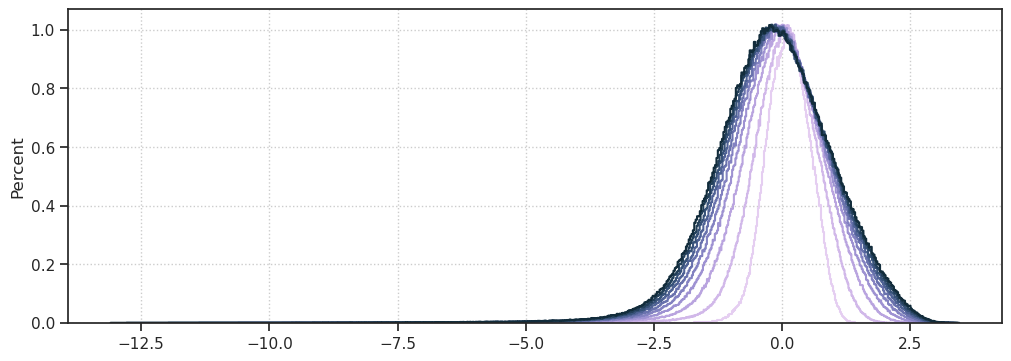

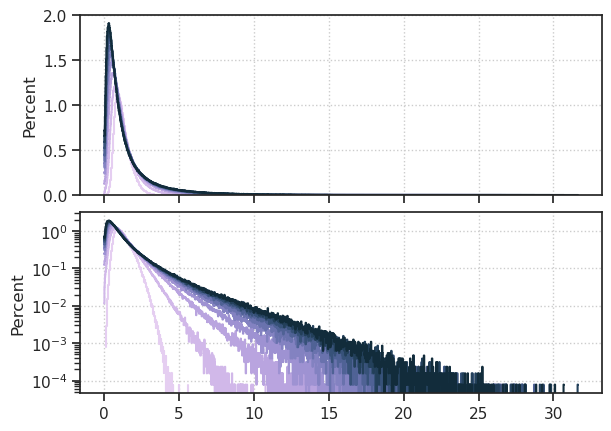

In [17]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [18]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8178323483750889, 0.7228373334284097, 0.9156857084467959],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.621433610824204, 0.5738491579616475, 0.8244120665462615],
 [0.5137602016853071, 0.5080741960907603, 0.7578471038208457],
 [0.41165859076399486, 0.44819771588937396, 0.6800995692970601],
 [0.3090934491249027, 0.3854178083786437, 0.5835384610223103],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.13614552585465997, 0.2501791993868458, 0.35455980691569594],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

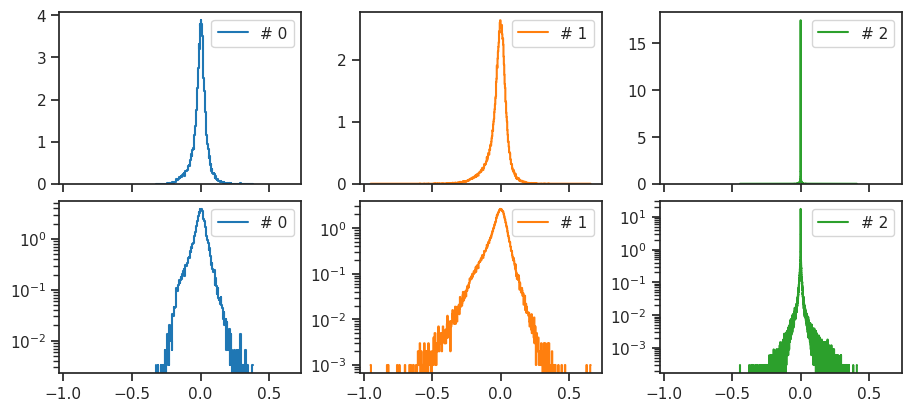

In [19]:
linear_layers = list(filter(
    lambda m: hasattr(m, 'weight'),
    tr.model.layer.dec,
))

fig, axes = create_figure(2, len(linear_layers), sharex='all')
for i, m in enumerate(linear_layers):
    if hasattr(m, 'weight'):
        w = m.weight.data
    for ax in axes[:, i]:
        sns.histplot(
            tonp(w.ravel()), 
            stat='percent',
            element='step',
            fill=False,
            label=f"# {i}",
            color=f"C{i}",
            ax=ax,
        )
    axes[0, i].set(yscale='linear', ylabel='')
    axes[1, i].set(yscale='log', ylabel='')
add_legend(axes)
plt.show()

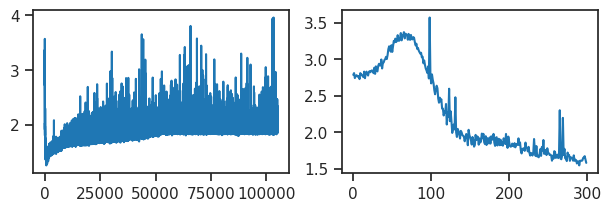

In [20]:
grad = np.array(list(tr.stats['grad'].values()))

fig, axes = create_figure(1, 2)
axes[0].plot(np.log(grad))
axes[1].plot(np.log(grad)[:300]);

In [21]:
(grad > 100).sum()

0

100%|█████████████████████████████████| 50/50 [01:29<00:00,  1.78s/it]


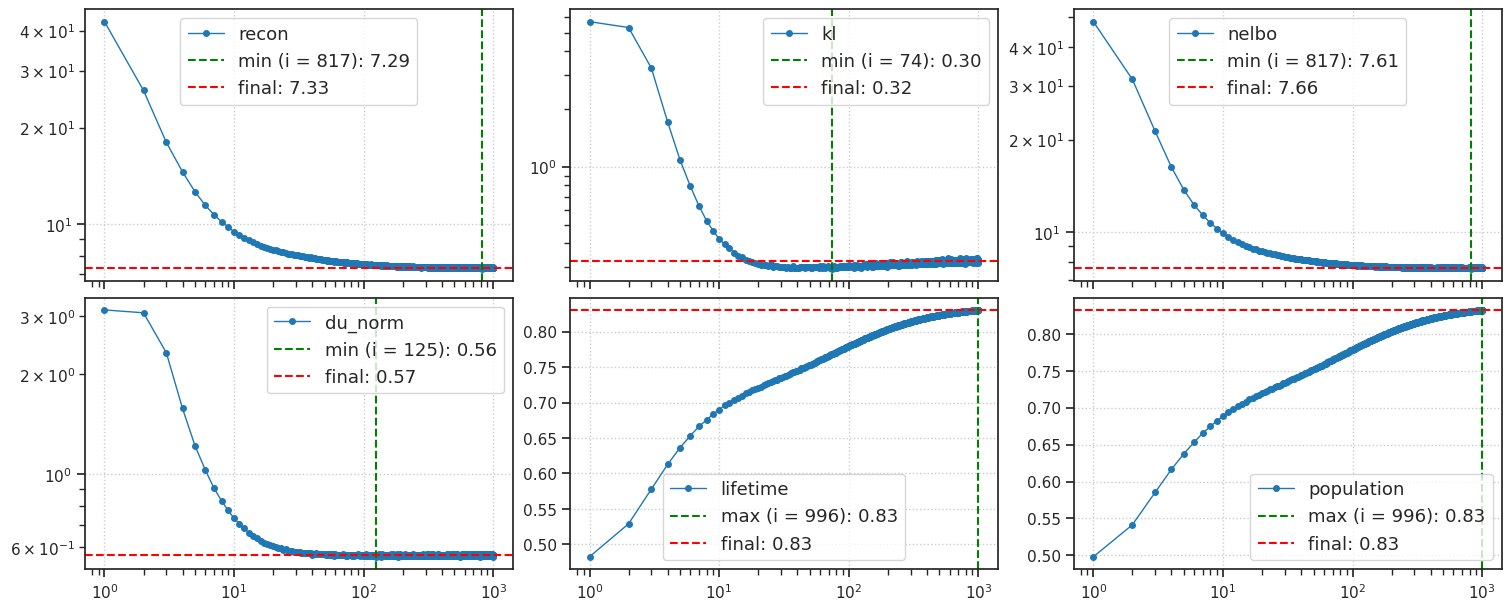

CPU times: user 1min 30s, sys: 1.56 s, total: 1min 32s
Wall time: 1min 31s


In [22]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='C0')

100%|█████████████████████████████████| 50/50 [01:36<00:00,  1.93s/it]


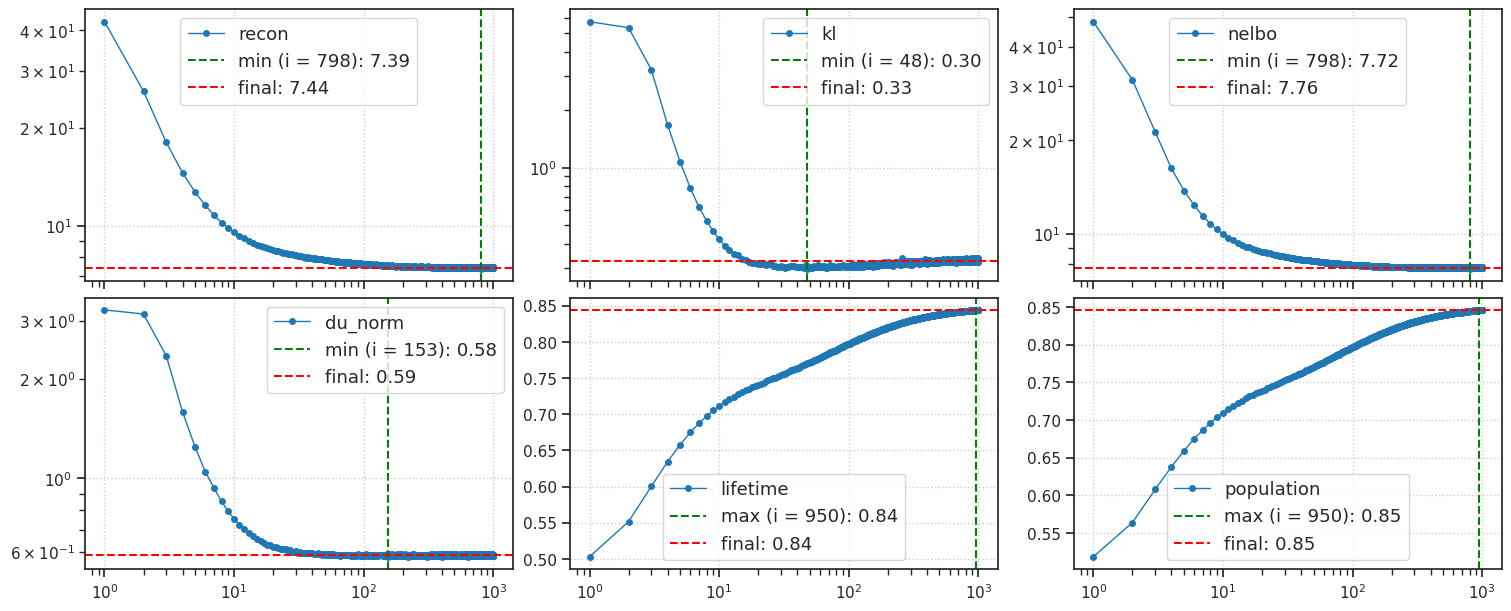

CPU times: user 1min 38s, sys: 927 ms, total: 1min 38s
Wall time: 1min 38s


In [24]:
## Was: warmup = 1, 350 epochs

## Poisson 

**Task:** reproduce gold standard but with 2/3 epochs (# iters)

Dataset: MNIST

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|mlp')

seq_len = 10

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_tr['kl_beta'] = 4/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

105000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  467.4 K   |
|     ———     |    ———     |
|    layer    |  467.4 K   |
+-------------+------------+

poisson_MNIST_t-10_z-[128]_<jacob|mlp>
b200-ep350-lr(0.002)_beta(5:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_15,10:33)

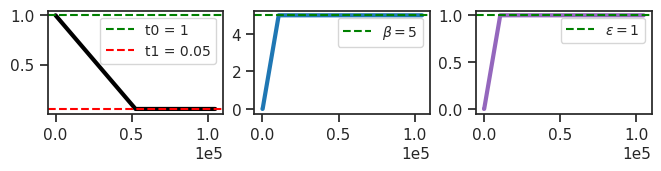

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  467.4 K   |
|     ———      |    ———     |
|     dec      |  467.1 K   |
+--------------+------------+

In [7]:
vae.layer.n_exp

tensor([271, 271, 271, 271, 271, 271, 271, 271, 271, 271], device='cuda:0',
       dtype=torch.int32)

In [8]:
vae.cfg.track_stats

True

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 10, 'n_latents': [128], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'MNIST', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_MNIST_t-10_z-[128]_<jacob|mlp>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_MNIST_t-10_z-[128]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 350, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 115.0, 'eta_min': 1e-05}, 'ema_rate': None, 'grad_clip': 50,
'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 5.0, 'kl_beta_min': 0.0001, 
'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 'kl_const_portion':
0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

In [10]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=234, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=234, out_features=428, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=428, out_features=784, bias=True)
)

### Fit model

In [11]:
tr.train()

epoch # 350, avg loss: 18.223770: 100%|███████| 350/350 [59:53<00:00, 10.27s/it]


**Task:** attempting to reproduce gold standard using 350 epochs (~2/3 original # iters)

**Conclusion:** It hurt a bit. For the final paper, use >= 150k iters 

In [12]:
print(vae.layer.n_exp)

tensor([17, 26, 35, 41, 45, 48, 50, 51, 52, 53], device='cuda:0',
       dtype=torch.int32)

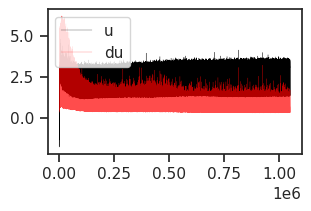

In [13]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

fig, ax = create_figure()
ax.plot(u_max, color='k', label='u', lw=0.2)
ax.plot(du_max, color='r', label='du', alpha=0.7, lw=0.2)
ax.legend()
plt.show()

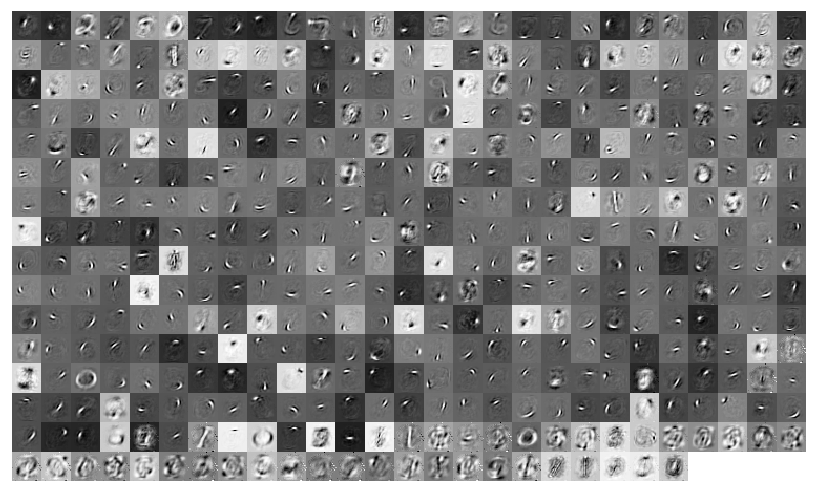

In [14]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))
tr.model.show(order=np.argsort(norms), dpi=120, pad=0);

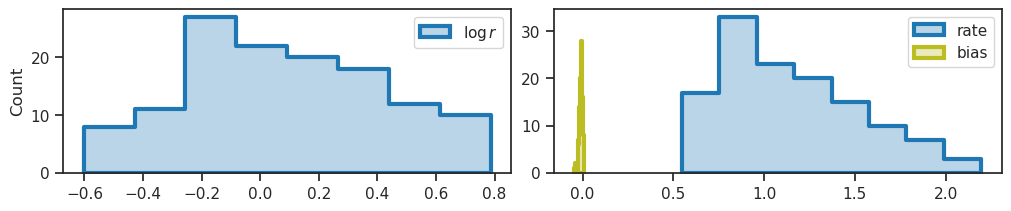

In [17]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [18]:
dead = log_rate < -1
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

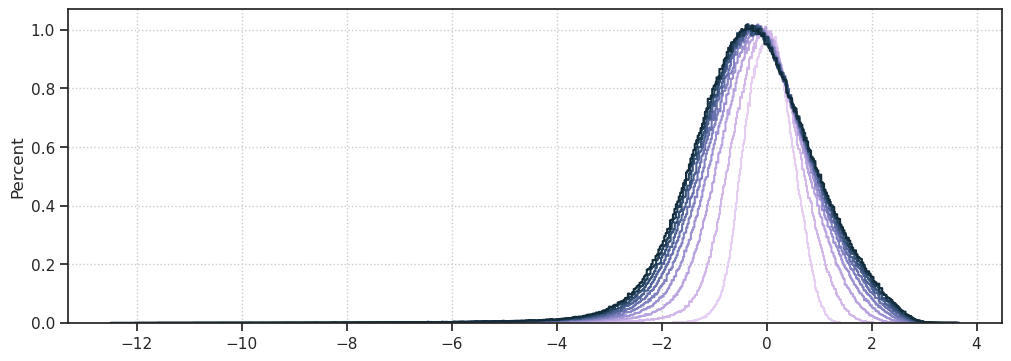

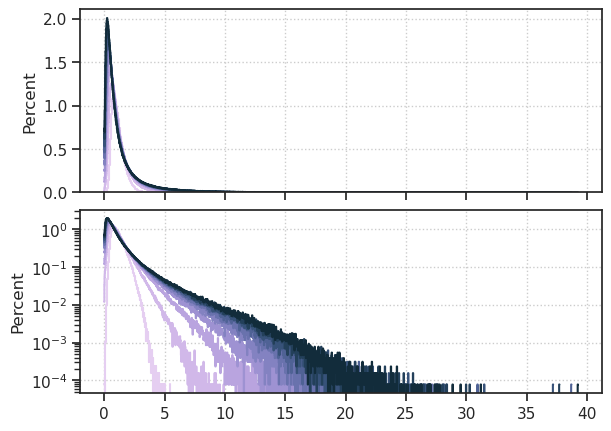

In [19]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [18]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8866123240173651, 0.7958983038519307, 0.9422918732191514],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8675492796390212, 0.7737271804565149, 0.9349467948701816],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8433620288876186, 0.7478796938980614, 0.9256448758128782],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8178323483750889, 0.7228373334284097, 0.9156857084467959],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.79560472689218, 0.7025635211553574, 0.906794768375293],
 [0.7818799577163285, 0.6906503712327243, 0.9011719061316577],
 [0.7678810179857369, 0.6789200520499765, 0.895316140152927],
 [0.7536222390910452, 0.6673676811663984, 0.8892145725288978],
 [0.7391183047885241, 0.6559880740597579, 0.8828549646148315],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.7094353267375394, 0.6337249583933606, 0.8693160528666957],
 [0.6993577385770928, 0.6264445294016456, 0.8645487063100135],
 [0.6840855914209351, 0.6156494043651438, 0.8571492616027769],
 [0.6686407796183966, 0.6049991340541501, 0.8494437689559234],
 [0.6530395351595674, 0.5944870054682074, 0.8414239655082867],
 [0.6372982819344618, 0.5841060706815461, 0.833082325095353],
 [0.621433610824204, 0.5738491579616475, 0.8244120665462615],
 [0.6107968559632122, 0.5670764791822508, 0.8184463202131744],
 [0.5947637311136256, 0.5570097609434238, 0.8092153420349645],
 [0.5786520562132055, 0.5470469330879013, 0.7996413582804732],
 [0.5624788192426652, 0.537180102140577, 0.7897203759647626],
 [0.5462610574079536, 0.5274012056922577, 0.7794491739582197],
 [0.5300158317387482, 0.5177020247219766, 0.7688253061707515],
 [0.5137602016853071, 0.5080741960907603, 0.7578471038208457],
 [0.502925747750803, 0.501691094016707, 0.750330978090829],
 [0.4866906022573988, 0.49216324991999744, 0.7387606248388815],
 [0.47049034368637177, 0.4826838485599901, 0.7268352944905869],
 [0.4543418090218264, 0.47324410768280234, 0.7145561729846717],
 [0.4382617158505203, 0.46383516111091816, 0.7019252220281831],
 [0.4222666374319871, 0.4544480719647567, 0.68894517617112],
 [0.41165859076399486, 0.44819771588937396, 0.6800995692970601],
 [0.3958415626832449, 0.4388270462167934, 0.6665458619228831],
 [0.3801528514238289, 0.42945415804726944, 0.6526540980753568],
 [0.3646082907403786, 0.42006996959797827, 0.6384298063533692],
 [0.34922345634459306, 0.41066539098359633, 0.6238792625699561],
 [0.3340136422551673, 0.4012313377379247, 0.609009481727145],
 [0.31899383745488447, 0.39175874434318986, 0.5938282091118987],
 [0.3090934491249027, 0.3854178083786437, 0.5835384610223103],
 [0.29442273406185093, 0.3758609301156636, 0.5678571993546726],
 [0.27998033375032055, 0.36624153240241375, 0.5518885932348213],
 [0.26577992459661565, 0.3565507347057864, 0.5356429755155622],
 [0.2518347737894646, 0.34677973827838704, 0.5191313564287725],
 [0.23815771813777506, 0.33691983947377085, 0.5023654098822408],
 [0.22919475837445644, 0.33029293394003856, 0.49105287836119443],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.20308894806968764, 0.31012716573160537, 0.45650855834617055],
 [0.1904972282574262, 0.2998687188513679, 0.4389202776631917],
 [0.17822722309223576, 0.2894823960320571, 0.4211404754406243],
 [0.1662889542130063, 0.27896027928163225, 0.40318428935094847],
 [0.158519102797742, 0.271866265196377, 0.39112323360373646],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.13614552585465997, 0.2501791993868458, 0.35455980691569594],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.11522562698887427, 0.22783962349552306, 0.3175316418450756],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.09581502618943258, 0.2047927589221381, 0.28018086136798226],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.08082544199115693, 0.18500996673171594, 0.24891610683615542],
 [0.

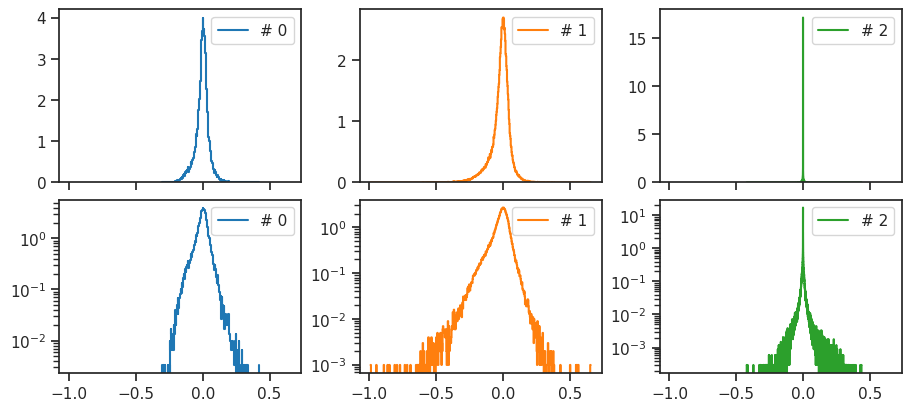

In [20]:
linear_layers = list(filter(
    lambda m: hasattr(m, 'weight'),
    tr.model.layer.dec,
))

fig, axes = create_figure(2, len(linear_layers), sharex='all')
for i, m in enumerate(linear_layers):
    if hasattr(m, 'weight'):
        w = m.weight.data
    for ax in axes[:, i]:
        sns.histplot(
            tonp(w.ravel()), 
            stat='percent',
            element='step',
            fill=False,
            label=f"# {i}",
            color=f"C{i}",
            ax=ax,
        )
    axes[0, i].set(yscale='linear', ylabel='')
    axes[1, i].set(yscale='log', ylabel='')
add_legend(axes)
plt.show()

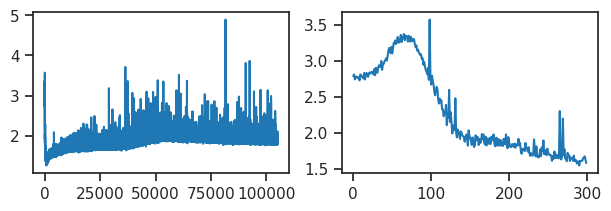

In [21]:
grad = np.array(list(tr.stats['grad'].values()))

fig, axes = create_figure(1, 2)
axes[0].plot(np.log(grad))
axes[1].plot(np.log(grad)[:300]);

In [22]:
(grad > 100).sum()

1

100%|█████████████████████████████████| 50/50 [01:36<00:00,  1.93s/it]


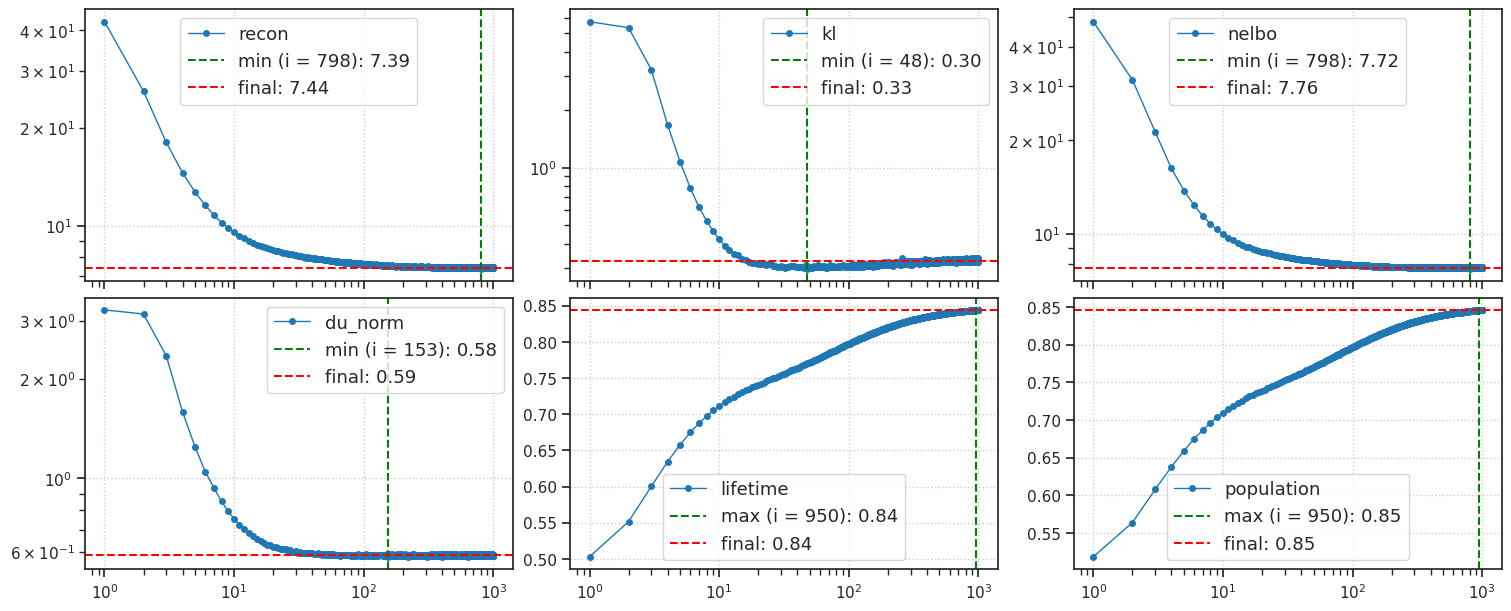

CPU times: user 1min 38s, sys: 927 ms, total: 1min 38s
Wall time: 1min 38s


In [24]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='C0')

## Poisson

Dataset: MNIST

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|mlp')

seq_len = 64

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_tr['kl_beta'] = 3/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

150000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  467.4 K   |
|     ———     |    ———     |
|    layer    |  467.4 K   |
+-------------+------------+

poisson_MNIST_t-64_z-[128]_<jacob|mlp>
b200-ep500-lr(0.002)_beta(24:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:13)

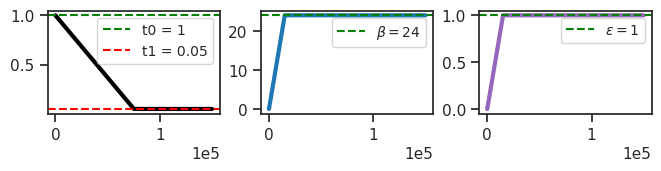

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  467.4 K   |
|     ———      |    ———     |
|     dec      |  467.1 K   |
+--------------+------------+

In [7]:
vae.layer.n_exp

tensor([271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271], device='cuda:0',
       dtype=torch.int32)

In [8]:
vae.cfg.track_stats

True

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 64, 'n_latents': [128], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'MNIST', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 500, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 165.0, 'eta_min': 1e-05}, 'ema_rate': None, 'grad_clip': 50,
'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 24.0, 'kl_beta_min': 0.0001, 
'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 'kl_const_portion':
0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

In [10]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=234, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=234, out_features=428, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=428, out_features=784, bias=True)
)

### Fit model

In [11]:
tr.train()

epoch # 500, avg loss: 9.057116: 100%|██████| 500/500 [6:41:14<00:00, 48.15s/it]


**Task:** Now doing slightly weaker beta: $T = 64$, $\beta = 3/8 * T = 24.0$,

- Done: halfway strength beta is fine: $T = 64$, $\beta = 2/4 * T = 32.0$,

- Done: still high beta, $T = 32$, $\beta = 5/4 * T = 40.0$,

- Done: higher beta, $T = 32$, $\beta = 6/4 * T = 48.0$, too strong, not useful.

- Done: lower beta: $(T, \beta) = (32, 8.0)$, will it diverge? Yes, diverged.

- Done: higher beta, $(T, \beta) = (32, 24.0)$, lead to more refined decoder features? No, but worse performance.

- Done: fitting a $(T, \beta) = (32, 16.0)$ model for the rotation test.

- Older experiment: added a 784 * 784 last layer, testing on gold standard: ```T = 10 / beta = 5.0``` (the goal was to see how dictionary elements change with additional filters).

In [12]:
print(vae.layer.n_exp)

tensor([17, 19, 22, 27, 32, 36, 40, 43, 46, 48, 50, 52, 54, 56, 57, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 67, 68, 68, 69, 69, 70, 70, 70, 71, 71, 71, 72,
        72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73, 73, 73, 73, 73, 73], device='cuda:0',
       dtype=torch.int32)

In [12]:
## Was (T, beta) = (32, 16.0)

tensor([15, 19, 24, 30, 36, 40, 44, 47, 50, 52, 54, 55, 57, 58, 59, 60, 61, 62,
        63, 63, 64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66],
       device='cuda:0', dtype=torch.int32)

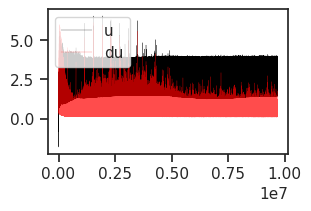

In [13]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

fig, ax = create_figure()
ax.plot(u_max, color='k', label='u', lw=0.2)
ax.plot(du_max, color='r', label='du', alpha=0.7, lw=0.2)
ax.legend()
plt.show()

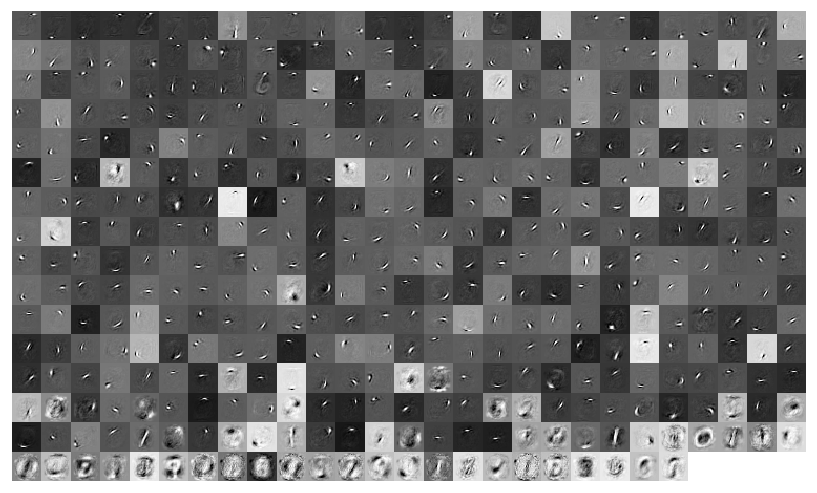

In [14]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))
tr.model.show(order=np.argsort(norms), dpi=120, pad=0);

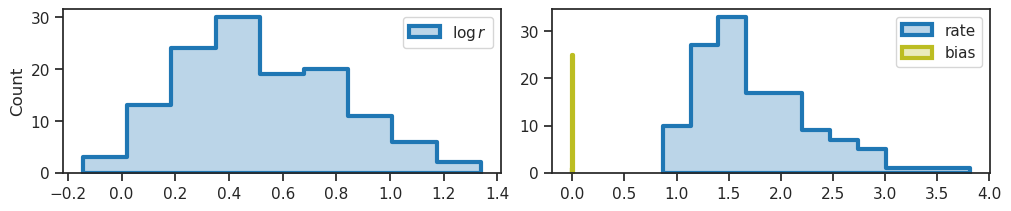

In [15]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [16]:
dead = log_rate < - 1
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

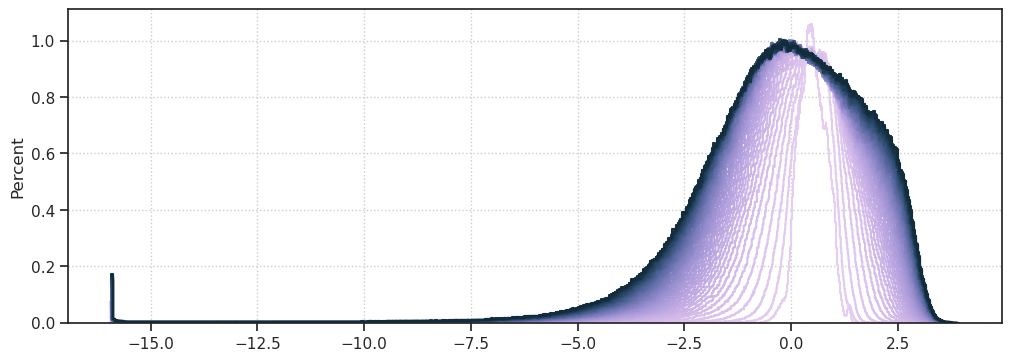

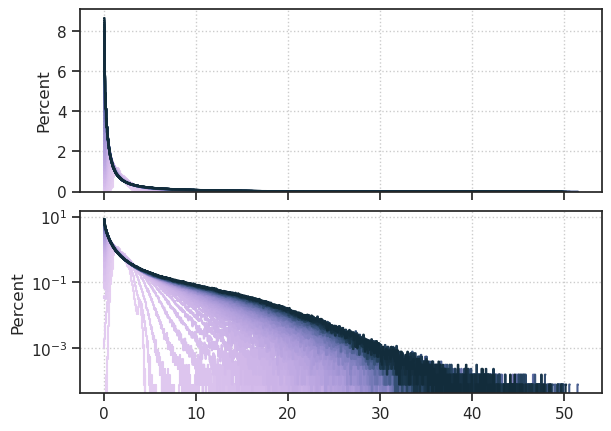

In [17]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [18]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8866123240173651, 0.7958983038519307, 0.9422918732191514],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8675492796390212, 0.7737271804565149, 0.9349467948701816],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8433620288876186, 0.7478796938980614, 0.9256448758128782],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8178323483750889, 0.7228373334284097, 0.9156857084467959],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.79560472689218, 0.7025635211553574, 0.906794768375293],
 [0.7818799577163285, 0.6906503712327243, 0.9011719061316577],
 [0.7678810179857369, 0.6789200520499765, 0.895316140152927],
 [0.7536222390910452, 0.6673676811663984, 0.8892145725288978],
 [0.7391183047885241, 0.6559880740597579, 0.8828549646148315],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.7094353267375394, 0.6337249583933606, 0.8693160528666957],
 [0.6993577385770928, 0.6264445294016456, 0.8645487063100135],
 [0.6840855914209351, 0.6156494043651438, 0.8571492616027769],
 [0.6686407796183966, 0.6049991340541501, 0.8494437689559234],
 [0.6530395351595674, 0.5944870054682074, 0.8414239655082867],
 [0.6372982819344618, 0.5841060706815461, 0.833082325095353],
 [0.621433610824204, 0.5738491579616475, 0.8244120665462615],
 [0.6107968559632122, 0.5670764791822508, 0.8184463202131744],
 [0.5947637311136256, 0.5570097609434238, 0.8092153420349645],
 [0.5786520562132055, 0.5470469330879013, 0.7996413582804732],
 [0.5624788192426652, 0.537180102140577, 0.7897203759647626],
 [0.5462610574079536, 0.5274012056922577, 0.7794491739582197],
 [0.5300158317387482, 0.5177020247219766, 0.7688253061707515],
 [0.5137602016853071, 0.5080741960907603, 0.7578471038208457],
 [0.502925747750803, 0.501691094016707, 0.750330978090829],
 [0.4866906022573988, 0.49216324991999744, 0.7387606248388815],
 [0.47049034368637177, 0.4826838485599901, 0.7268352944905869],
 [0.4543418090218264, 0.47324410768280234, 0.7145561729846717],
 [0.4382617158505203, 0.46383516111091816, 0.7019252220281831],
 [0.4222666374319871, 0.4544480719647567, 0.68894517617112],
 [0.41165859076399486, 0.44819771588937396, 0.6800995692970601],
 [0.3958415626832449, 0.4388270462167934, 0.6665458619228831],
 [0.3801528514238289, 0.42945415804726944, 0.6526540980753568],
 [0.3646082907403786, 0.42006996959797827, 0.6384298063533692],
 [0.34922345634459306, 0.41066539098359633, 0.6238792625699561],
 [0.3340136422551673, 0.4012313377379247, 0.609009481727145],
 [0.31899383745488447, 0.39175874434318986, 0.5938282091118987],
 [0.3090934491249027, 0.3854178083786437, 0.5835384610223103],
 [0.29442273406185093, 0.3758609301156636, 0.5678571993546726],
 [0.27998033375032055, 0.36624153240241375, 0.5518885932348213],
 [0.26577992459661565, 0.3565507347057864, 0.5356429755155622],
 [0.2518347737894646, 0.34677973827838704, 0.5191313564287725],
 [0.23815771813777506, 0.33691983947377085, 0.5023654098822408],
 [0.22919475837445644, 0.33029293394003856, 0.49105287836119443],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.20308894806968764, 0.31012716573160537, 0.45650855834617055],
 [0.1904972282574262, 0.2998687188513679, 0.4389202776631917],
 [0.17822722309223576, 0.2894823960320571, 0.4211404754406243],
 [0.1662889542130063, 0.27896027928163225, 0.40318428935094847],
 [0.158519102797742, 0.271866265196377, 0.39112323360373646],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.13614552585465997, 0.2501791993868458, 0.35455980691569594],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.11522562698887427, 0.22783962349552306, 0.3175316418450756],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.09581502618943258, 0.2047927589221381, 0.28018086136798226],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.08082544199115693, 0.18500996673171594, 0.24891610683615542],
 [0.

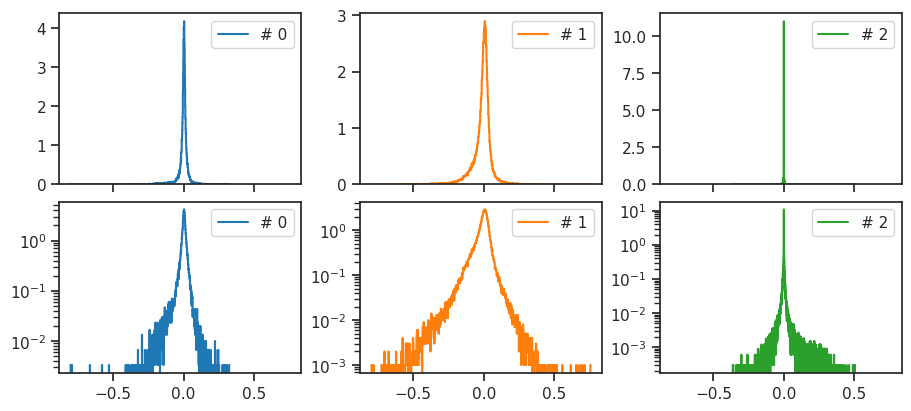

In [19]:
linear_layers = list(filter(
    lambda m: hasattr(m, 'weight'),
    tr.model.layer.dec,
))

fig, axes = create_figure(2, len(linear_layers), sharex='all')
for i, m in enumerate(linear_layers):
    if hasattr(m, 'weight'):
        w = m.weight.data
    for ax in axes[:, i]:
        sns.histplot(
            tonp(w.ravel()), 
            stat='percent',
            element='step',
            fill=False,
            label=f"# {i}",
            color=f"C{i}",
            ax=ax,
        )
    axes[0, i].set(yscale='linear', ylabel='')
    axes[1, i].set(yscale='log', ylabel='')
add_legend(axes)
plt.show()

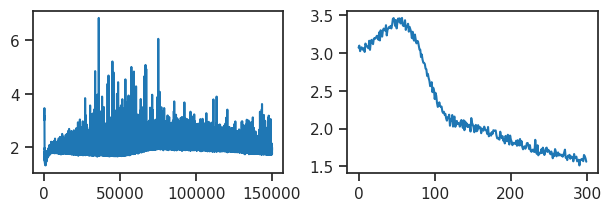

In [20]:
grad = np.array(list(tr.stats['grad'].values()))

fig, axes = create_figure(1, 2)
axes[0].plot(np.log(grad))
axes[1].plot(np.log(grad)[:300]);

In [21]:
(grad > 100).sum()

11

100%|█████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]


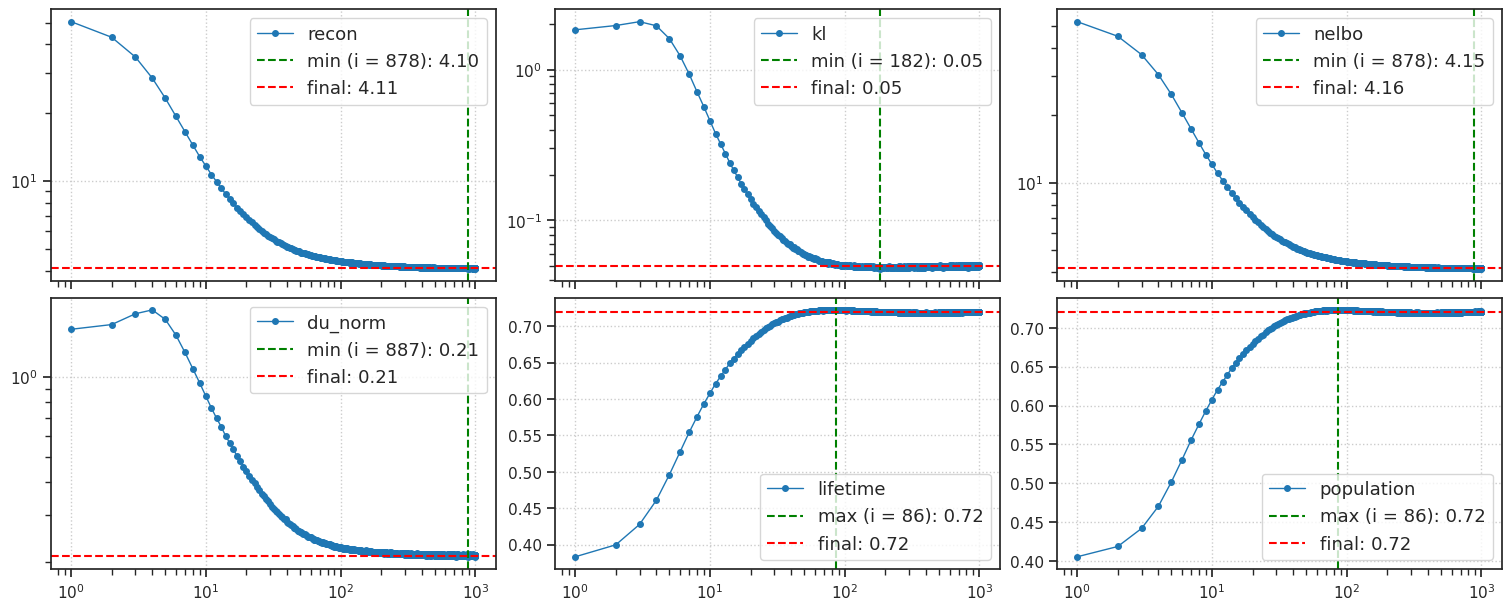

CPU times: user 2min 15s, sys: 3.4 s, total: 2min 19s
Wall time: 2min 29s


In [22]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='C0')

100%|█████████████████████████████████| 50/50 [23:16<00:00, 27.93s/it]


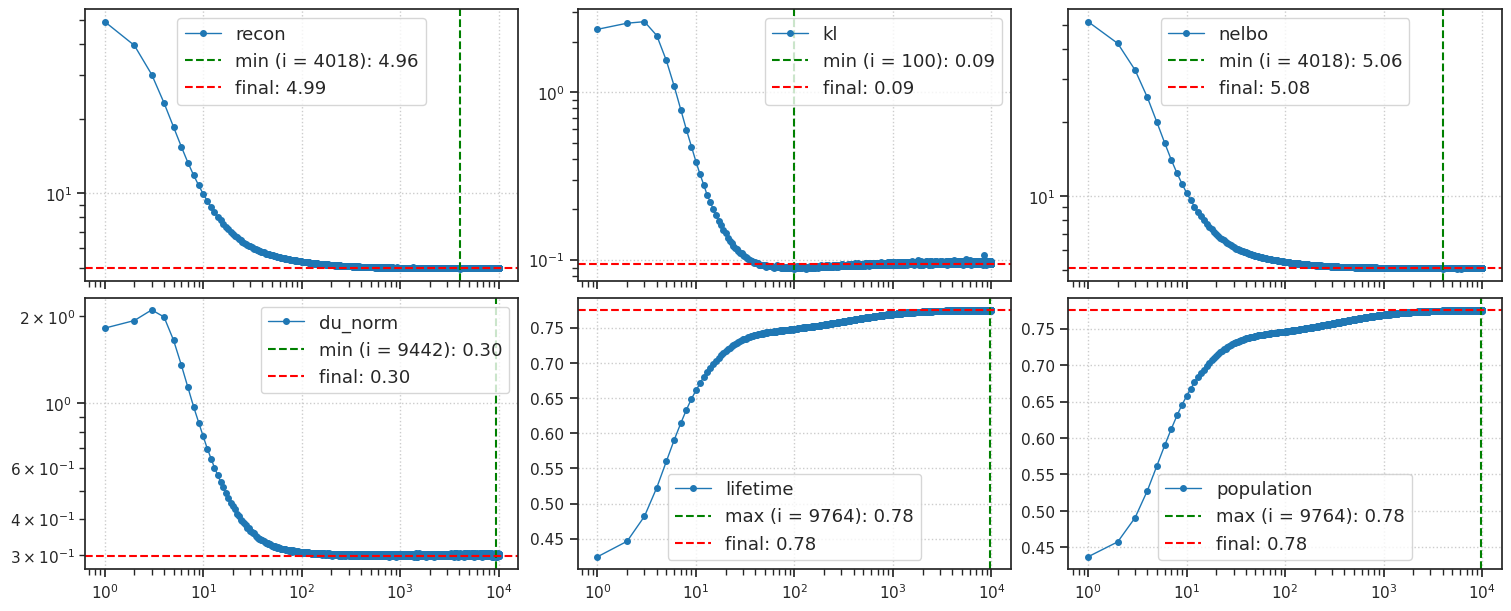

CPU times: user 23min 15s, sys: 16.5 s, total: 23min 32s
Wall time: 23min 30s


In [22]:
## T = 32, beta = 16.0

100%|█████████████████████████████████| 50/50 [02:19<00:00,  2.79s/it]


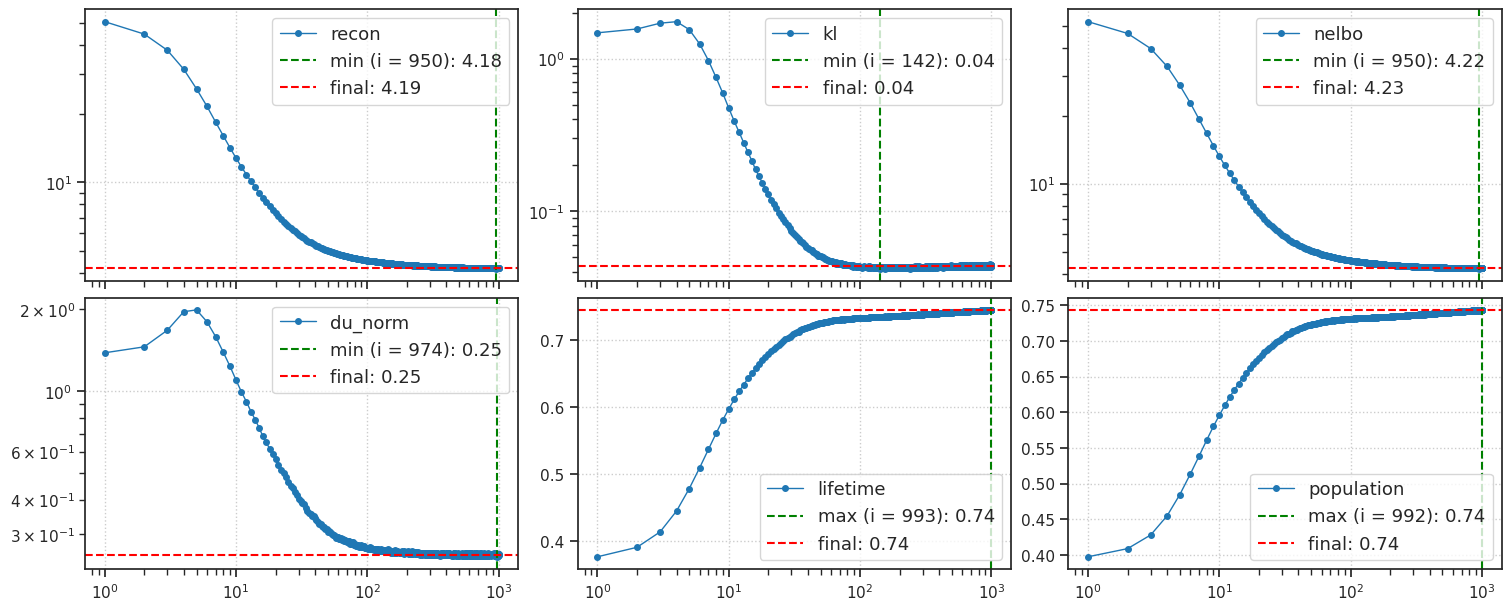

CPU times: user 2min 22s, sys: 823 ms, total: 2min 23s
Wall time: 2min 22s


In [23]:
## T = 64, beta = 32.0

100%|█████████████████████████████████| 50/50 [02:51<00:00,  3.43s/it]


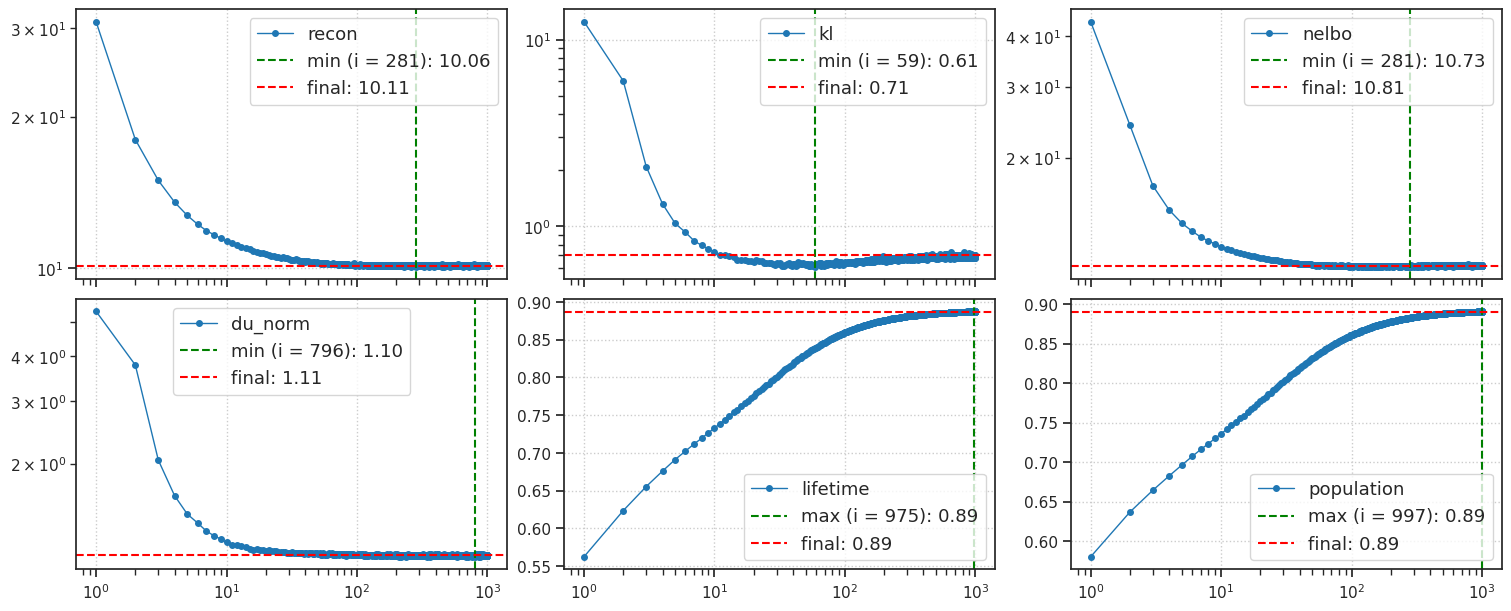

CPU times: user 2min 52s, sys: 1.95 s, total: 2min 54s
Wall time: 2min 54s


In [35]:
## Was: T = 4  /  beta = 2.0

**Gold standard:** (final, with kl_anneal_portion = 0.1)

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

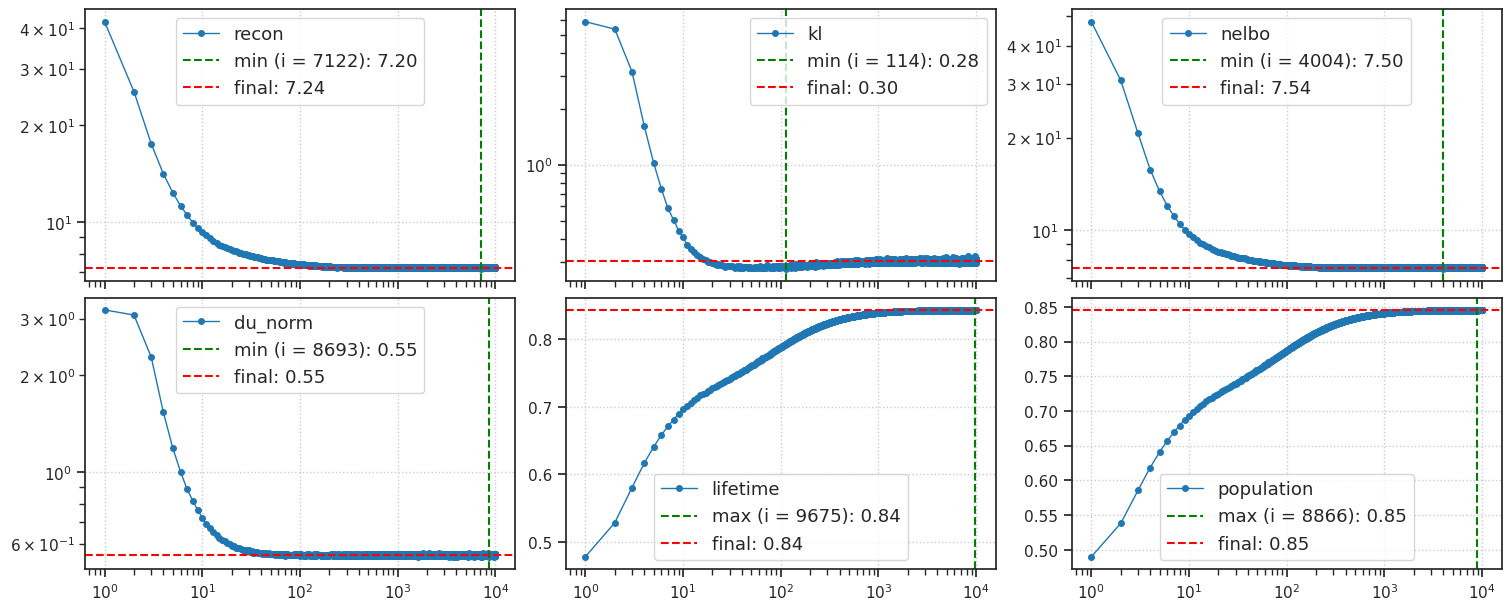

In [40]:
## Gold standard: T = 10  /  beta = 5.0

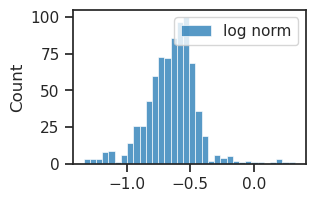

In [47]:
w = tr.model.layer.get_weight(reshape=False)
norms = tonp(torch.linalg.vector_norm(w, dim=1))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

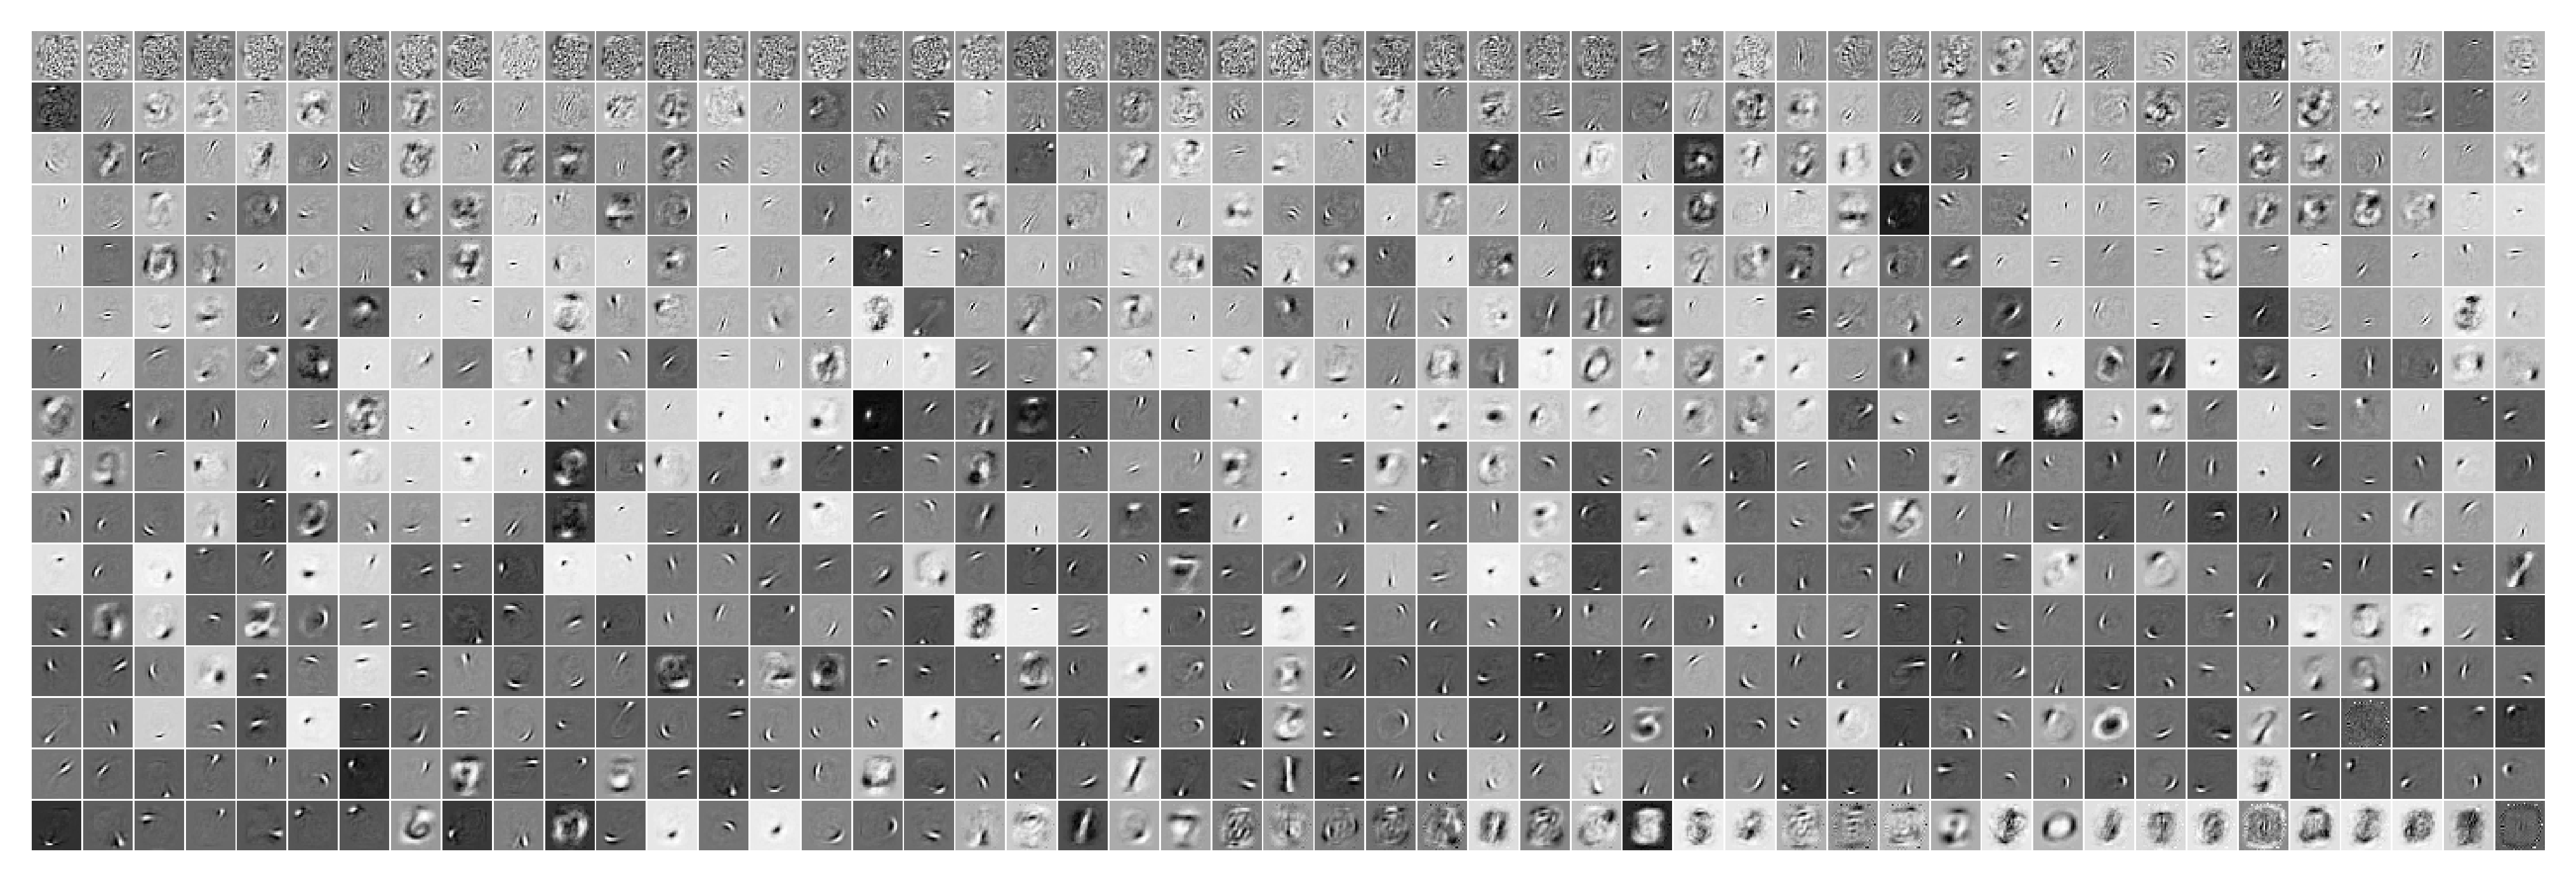

In [48]:
_ = tr.model.show(order=np.argsort(norms), dpi=500)

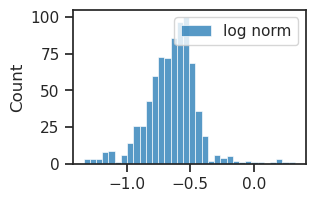

## Poisson (Gold Standard)

Dataset: MNIST

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|mlp')

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = 64

cfg_tr['kl_beta'] = 32.0

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

150000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  467.4 K   |
|     ———     |    ———     |
|    layer    |  467.4 K   |
+-------------+------------+

poisson_MNIST_t-64_z-[128]_<jacob|mlp>
b200-ep500-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_12,18:48)

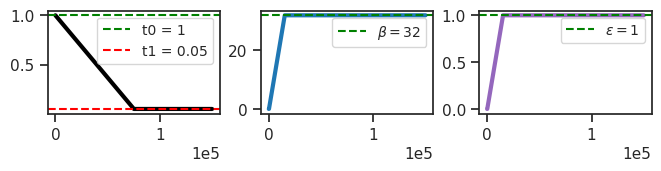

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  467.4 K   |
|     ———      |    ———     |
|     dec      |  467.1 K   |
+--------------+------------+

In [7]:
vae.layer.n_exp

tensor([271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271], device='cuda:0',
       dtype=torch.int32)

In [8]:
vae.cfg.track_stats

True

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 64, 'n_latents': [128], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'MNIST', 'input_sz': (1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 'init_dist': 'normal', 
'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'use_bn': False, 'use_se': True, 'track_stats': 
True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': '/home/hadi/Datasets', 'runs_dir': 
'/home/hadi/Projects/PoissonVAE/runs/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 'mods_dir': 
'/home/hadi/Projects/PoissonVAE/models/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 500, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_epochs': 5, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'T_max': 165.0, 'eta_min': 1e-05}, 'ema_rate': None, 'grad_clip': 50,
'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'use_amp': False, 'method': 'mc', 'kl_beta': 32.0, 
'kl_beta_min': 0.0001, 'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 
0.1, 'kl_const_portion': 0.001, 'lambda_anneal': False, 'lambda_init': 0.0, 'lambda_norm': 0.0, 
'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

In [10]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=234, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=234, out_features=428, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=428, out_features=784, bias=True)
)

### Fit model

In [ ]:
tr.train(f"u:({tr.model.cfg.clamp_u})-du:({tr.model.cfg.clamp_du})_{tr.cfg.name()}")

epoch # 1, avg loss: 31.090649:   0%|         | 1/500 [00:50<7:03:20, 50.90s/it]

Task: ```T = 10 / beta = 5.0``` gold standard, but now with an additional hidden layer in the MLP decoder.

In [ ]:
print(vae.layer.n_exp)

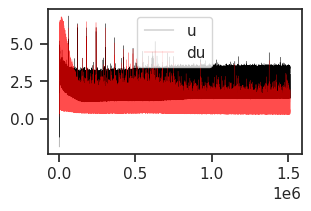

In [14]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

fig, ax = create_figure()
ax.plot(u_max, color='k', label='u', lw=0.2)
ax.plot(du_max, color='r', label='du', alpha=0.7, lw=0.2)
ax.legend()
plt.show()

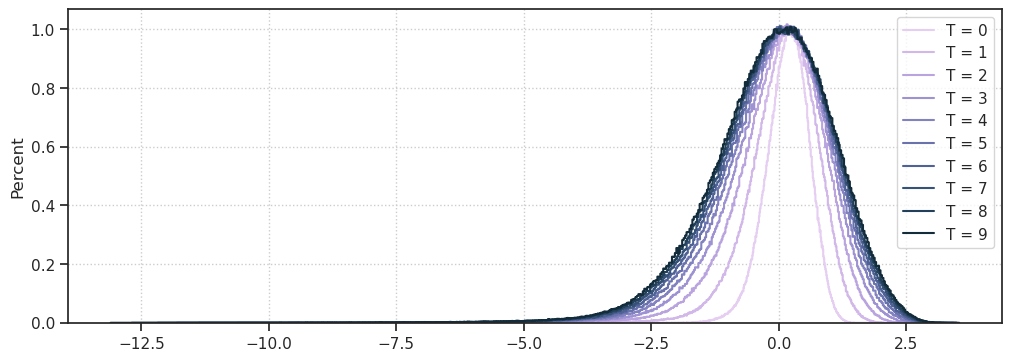

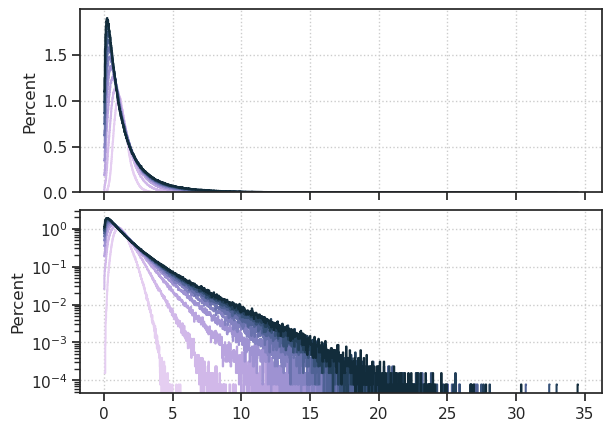

In [15]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v.ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [16]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8178323483750889, 0.7228373334284097, 0.9156857084467959],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.621433610824204, 0.5738491579616475, 0.8244120665462615],
 [0.5137602016853071, 0.5080741960907603, 0.7578471038208457],
 [0.41165859076399486, 0.44819771588937396, 0.6800995692970601],
 [0.3090934491249027, 0.3854178083786437, 0.5835384610223103],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.13614552585465997, 0.2501791993868458, 0.35455980691569594],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

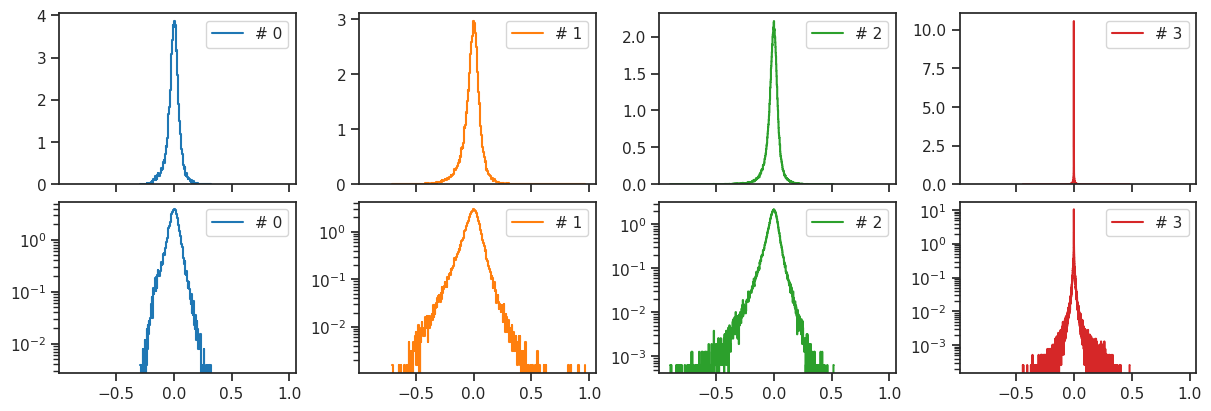

In [17]:
linear_layers = list(filter(
    lambda m: hasattr(m, 'weight'),
    tr.model.layer.dec,
))

fig, axes = create_figure(2, len(linear_layers), sharex='all')
for i, m in enumerate(linear_layers):
    if hasattr(m, 'weight'):
        w = m.weight.data
    for ax in axes[:, i]:
        sns.histplot(
            tonp(w.ravel()), 
            stat='percent',
            element='step',
            fill=False,
            label=f"# {i}",
            color=f"C{i}",
            ax=ax,
        )
    axes[0, i].set(yscale='linear', ylabel='')
    axes[1, i].set(yscale='log', ylabel='')
add_legend(axes)
plt.show()

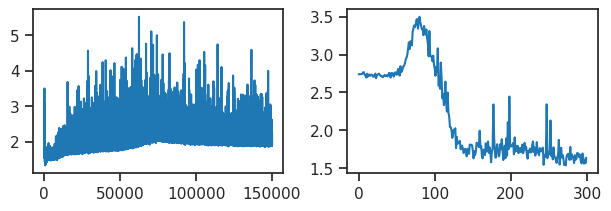

In [18]:
grad = np.array(list(tr.stats['grad'].values()))

fig, axes = create_figure(1, 2)
axes[0].plot(np.log(grad))
axes[1].plot(np.log(grad)[:300]);

In [19]:
(grad > 100).sum()

8

In [20]:
tr.n_iters * 1e-3

150.0

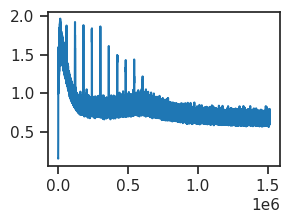

In [21]:
w = 25
sigma = 10

x2p = sp_img.gaussian_filter1d(
    tr.model.stats['du_max'],
    sigma=sigma,
    truncate=w/(2*sigma),
)
plt.plot(x2p);

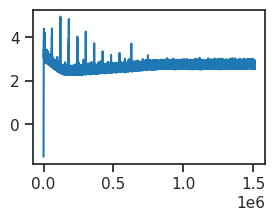

In [22]:
w = 25
sigma = 10

x2p = sp_img.gaussian_filter1d(
    tr.model.stats['u_max'],
    sigma=sigma,
    truncate=w/(2*sigma),
)
plt.plot(x2p);

In [32]:
# model_name = 'poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
# fit_name = 'fina-nexp-per-time-1e-6_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_09,20:52)'
# tr, meta = load_model(model_name, fit_name, device=device)

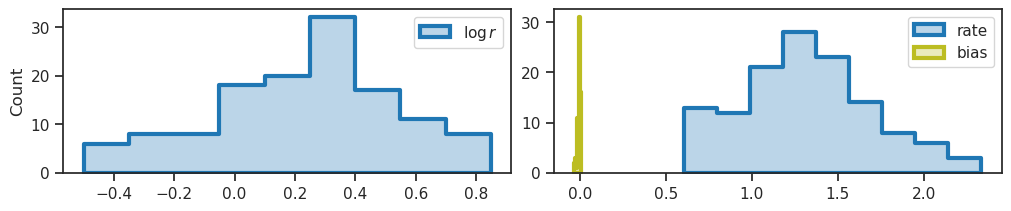

In [23]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [24]:
dead = log_rate < - 3.0
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

100%|█████████████████████████████████| 50/50 [02:32<00:00,  3.05s/it]


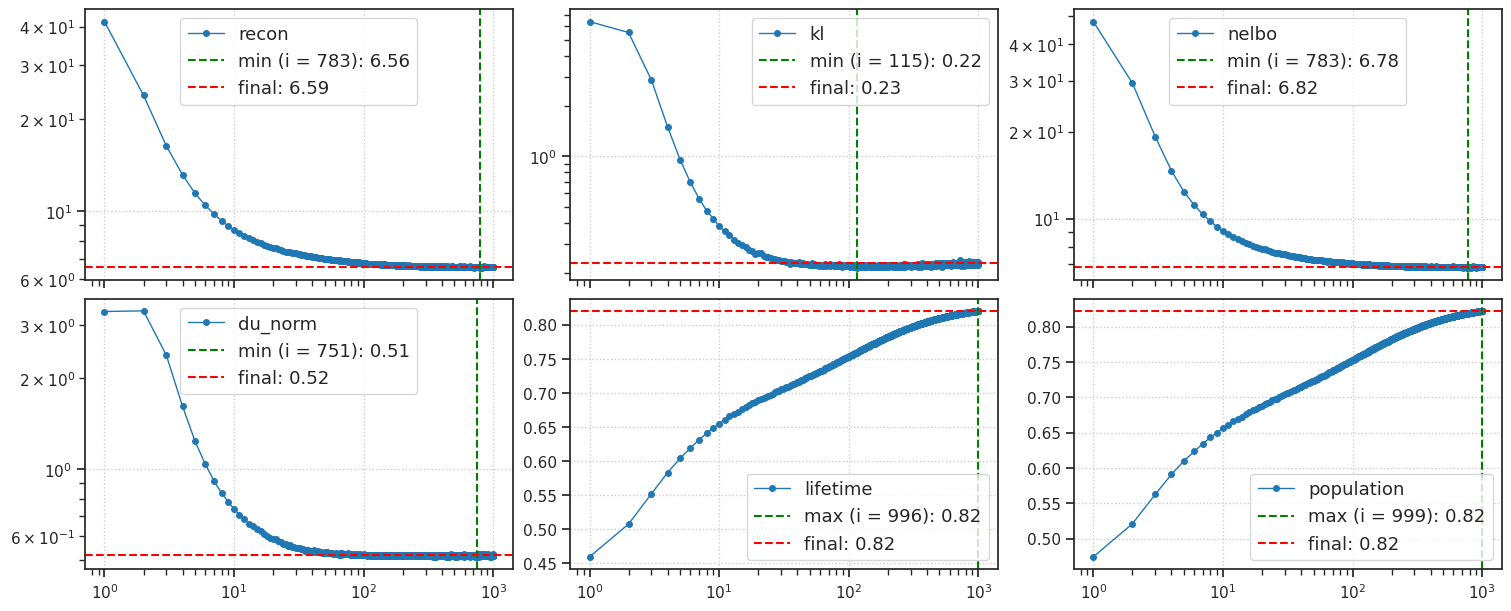

CPU times: user 2min 33s, sys: 1.88 s, total: 2min 35s
Wall time: 2min 35s


In [26]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl_name='vld', **kws)
_ = plot_convergence(results, color='C0')

100%|█████████████████████████████████| 50/50 [02:51<00:00,  3.43s/it]


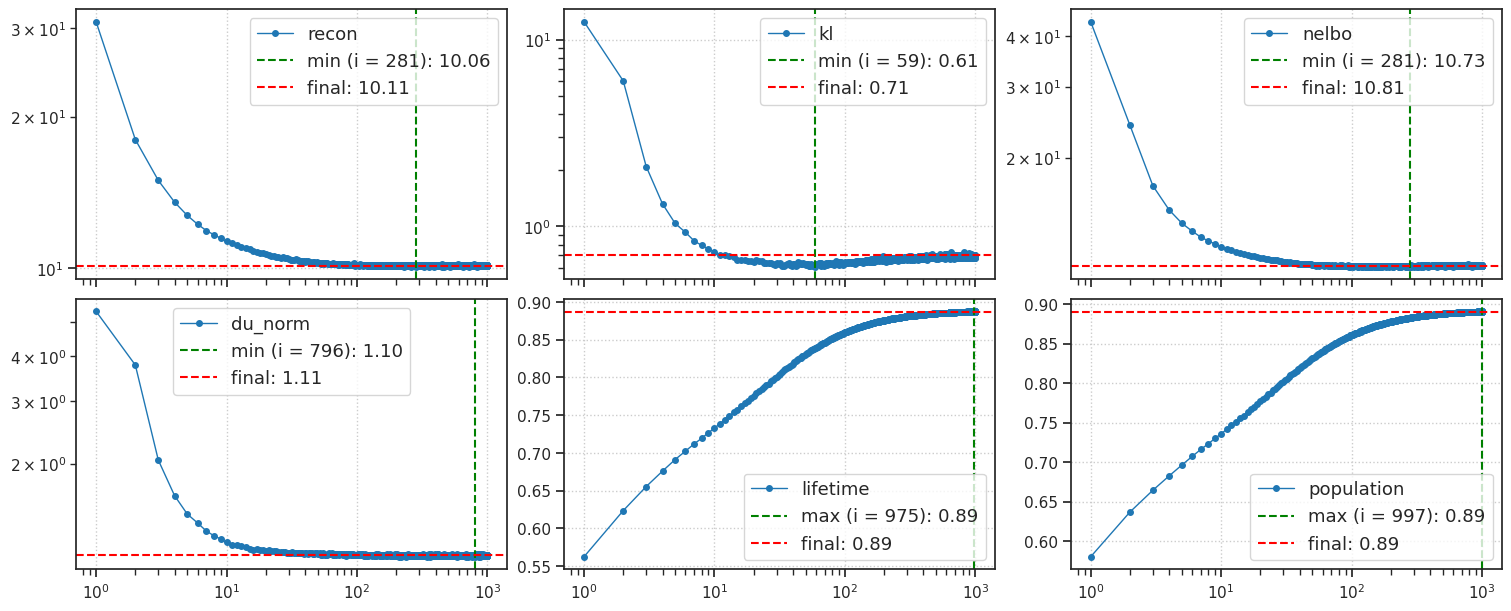

CPU times: user 2min 52s, sys: 1.95 s, total: 2min 54s
Wall time: 2min 54s


In [35]:
## Was: T = 4  /  beta = 2.0

**Gold standard:** (final, with kl_anneal_portion = 0.1)

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

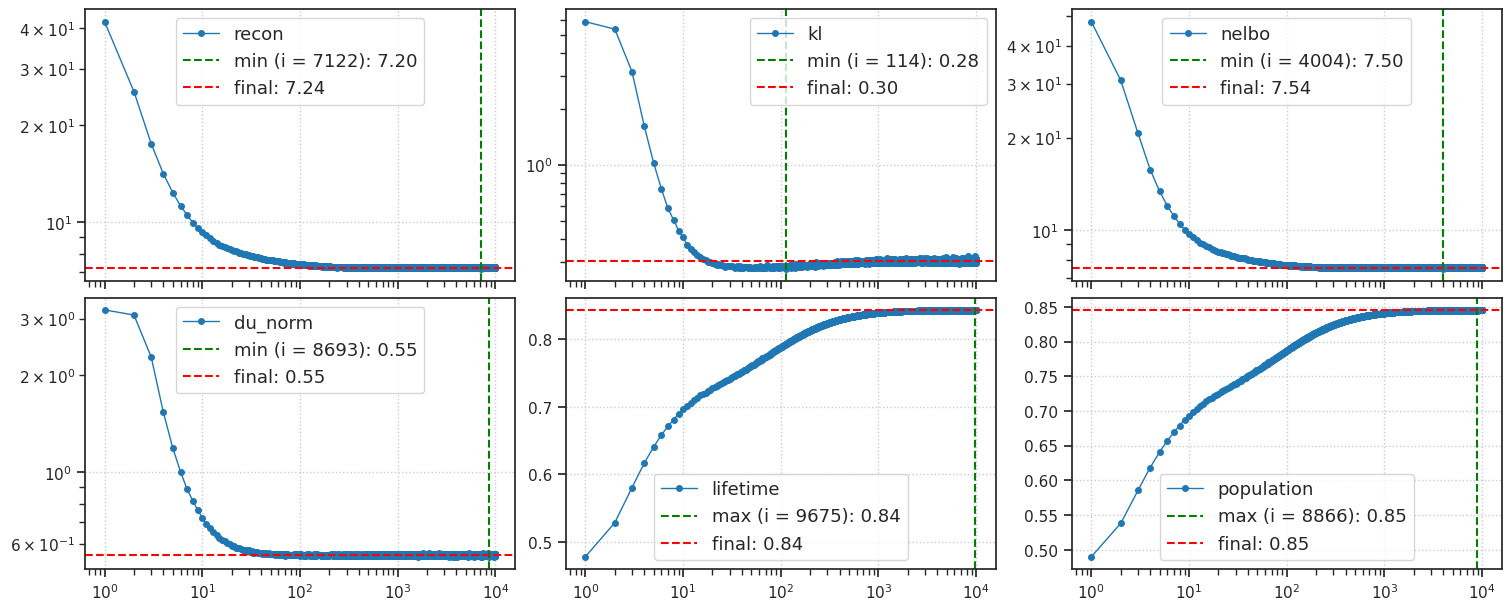

In [40]:
## Gold standard: T = 10  /  beta = 5.0

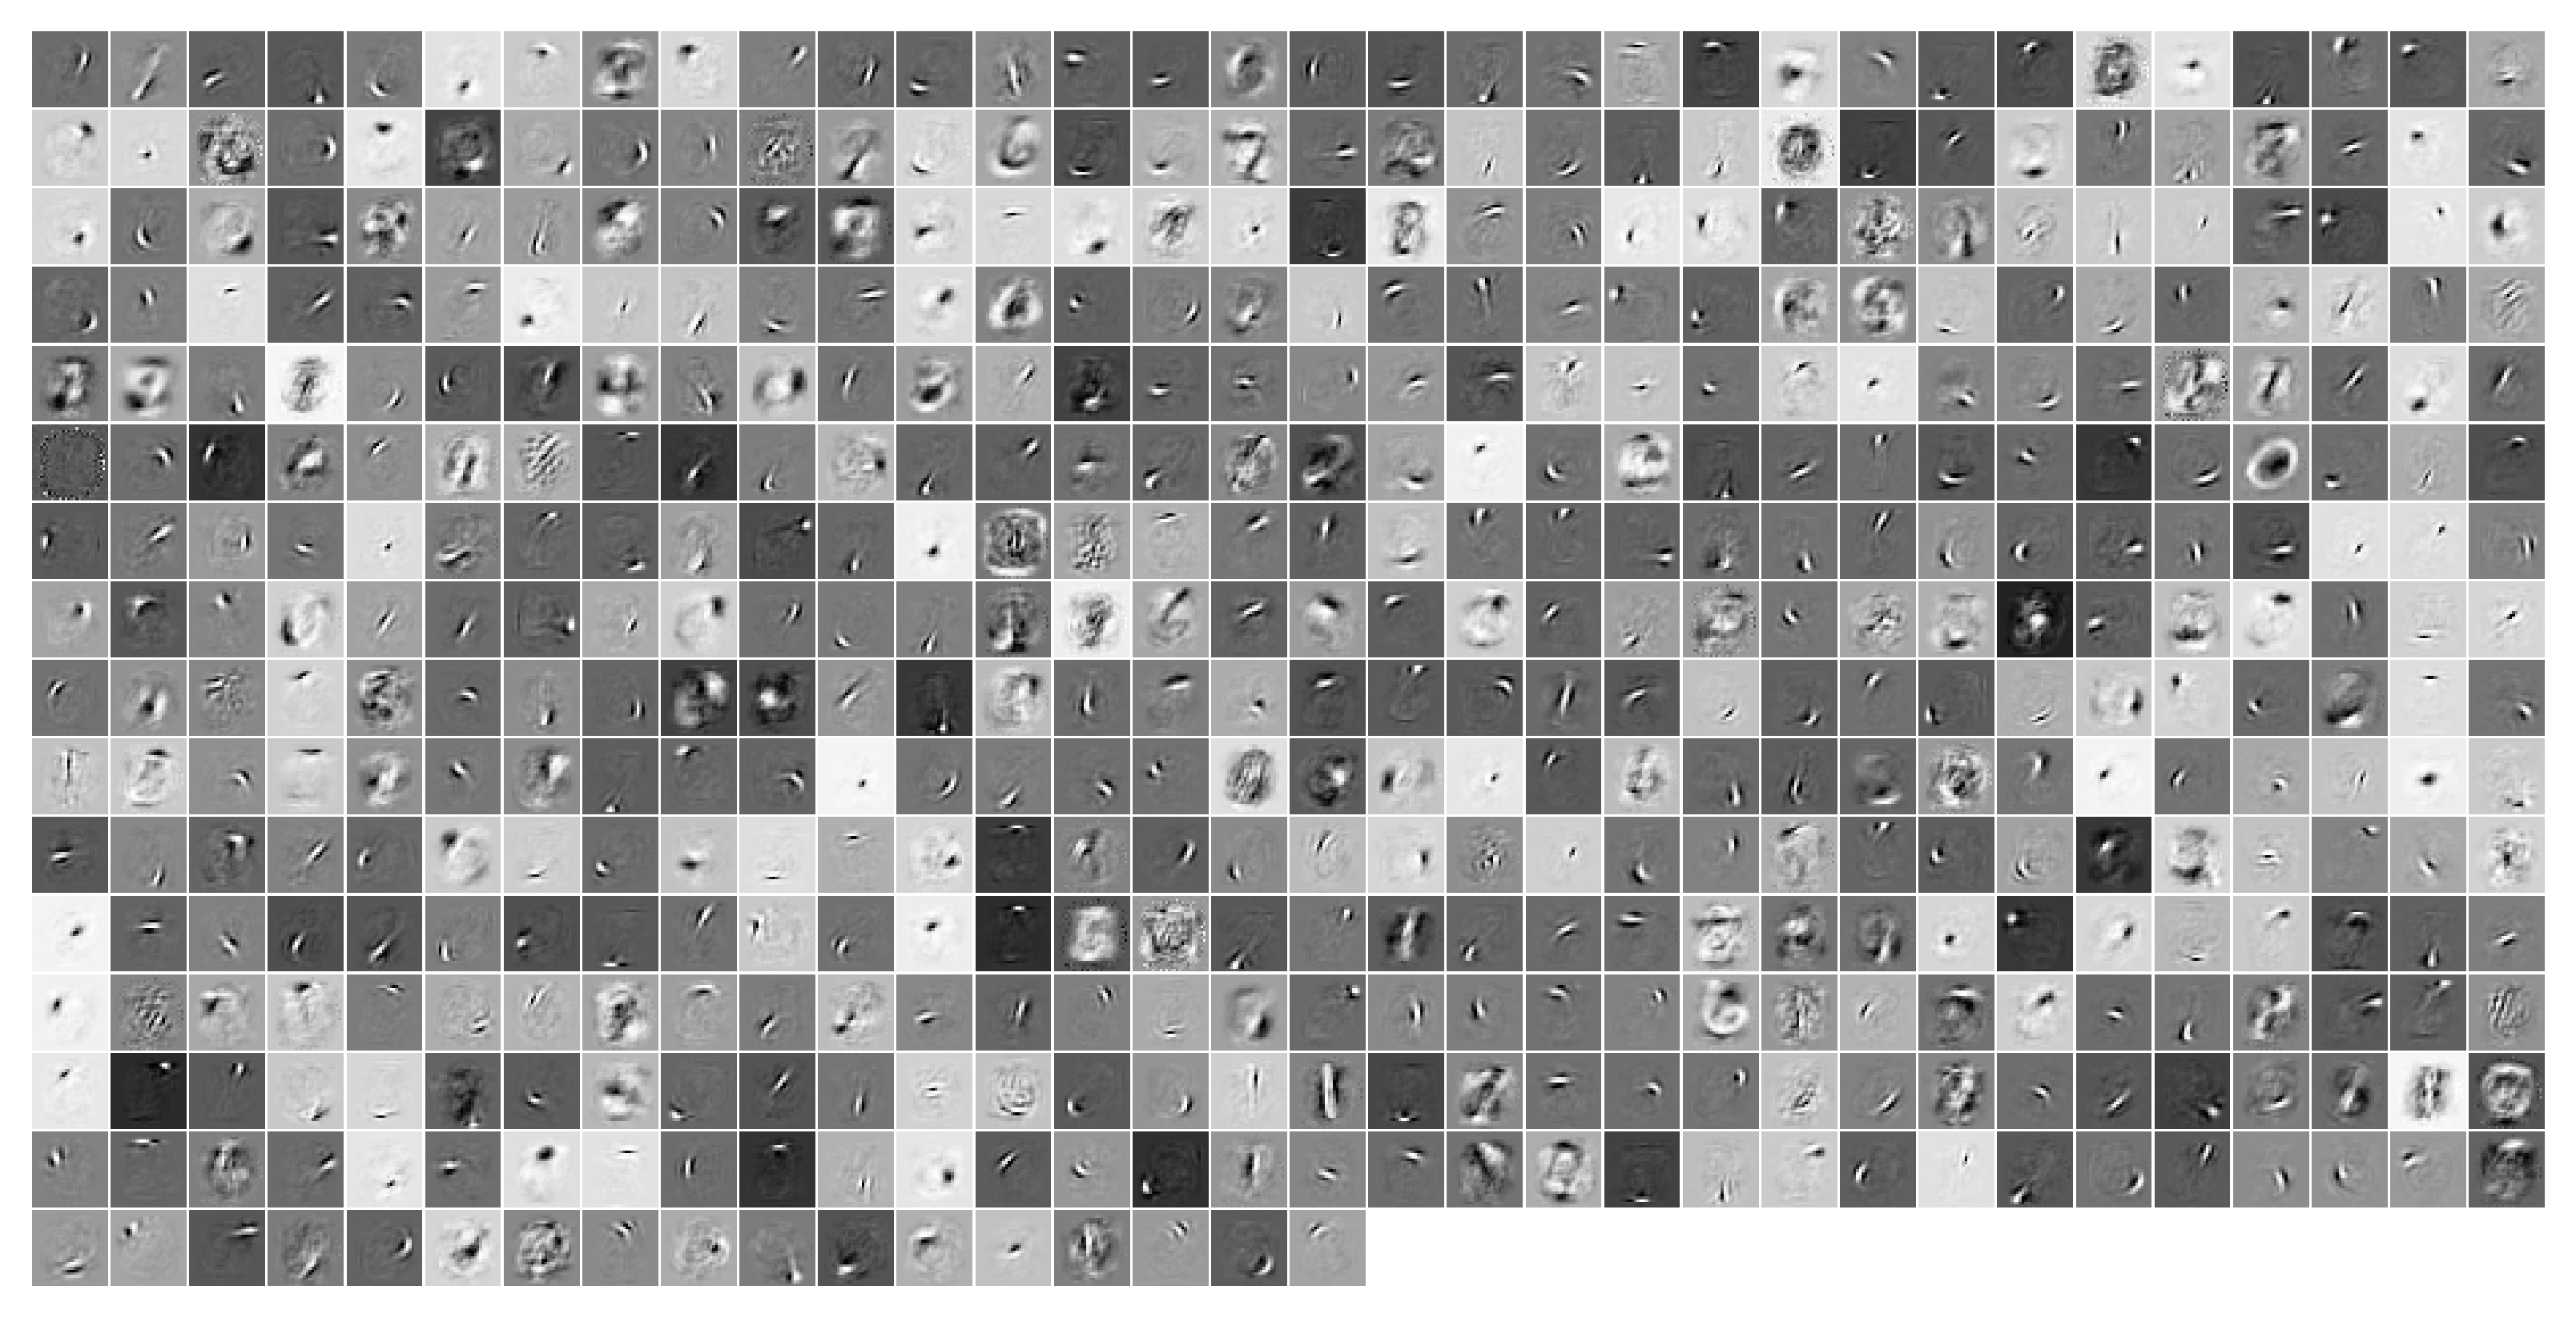

In [28]:
w = tonp(tr.model.layer.dec[-1].weight.data)
w = w.T.reshape(-1, 28, 28)

_ = plot_weights(w, nrows=16, dpi=400)